This Notebook Analyze each years data separately

In [ ]:
from google.colab import drive
import os 
drive.mount('/gdrive/')

Mounted at /gdrive/


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
#!pip install pyarrow
! pip install PyAstronomy

     |████████████████████████████████| 727 kB 4.1 MB/s 
     |████████████████████████████████| 85 kB 5.2 MB/s 
  Created wheel for PyAstronomy: filename=PyAstronomy-0.17.0-py3-none-any.whl size=522050 sha256=c2f77767b29ed6dbbe0a49c30b4dfa38807610a5b56a1713046e4d7f819cedeb
  Stored in directory: /root/.cache/pip/wheels/10/f4/cc/fe117c538c81443a6ba0e852ee8d69866a08e5163d2050aae5
  Created wheel for quantities: filename=quantities-0.12.5-py3-none-any.whl size=80135 sha256=e140793bf1a97aca370cab66aaab5cb1a8e3431ab3021dfb5f5a55912ee8940a
  Stored in directory: /root/.cache/pip/wheels/67/e7/32/0bb6d5bd0f619e583b6f1f4c710b535df898a1083e1e5d066c
Successfully built PyAstronomy quantities


In [ ]:
import pandas as pd
import time
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import statsmodels.api as sm
from sklearn.metrics import classification_report, roc_curve, auc

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### split into yearly data 

(Run it for the first time, after yearly files are saved, no need to run again)

In [ ]:
data = pd.read_parquet('/gdrive/MyDrive/traffic_stop/traffic.parquet', engine = 'pyarrow')

In [ ]:
data['year'] = pd.to_datetime(data['date']).dt.year

In [ ]:
years = []
for i in range(2006, 2018):
  years.append(i)
years

[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]

In [ ]:
for year in years:
  data_write = data[data['year'] == year]
  file_name = 'traffic_' + str(year)
  path = '/gdrive/MyDrive/traffic_stop/year_data/' + file_name + '.parquet'
  data_write.to_parquet(path, engine='pyarrow')

#### data Preprocessing

*   Remove rows with missing values in race, county_name, violation, and sex.
*   Added violation type filter (see violation_type parameter in function 'preprocessing'): 

1) if default: include all observations regardless of the violation types 

2) if 'speed': include only observations where at least have 1 violation contain 'speed' 

3) if 'speed_exclusive': include only observations where ALL of the violations are related to speeding

*   Convert county type & add time fraction variables (as before)



In [ ]:
keep_col = ['date', 
                'time', 
                'county_name', 
                'subject_race',
                'subject_sex',
                'violation', 
                'citation_issued',
                'contraband_found',
                'contraband_drugs',
                'contraband_weapons',
                'search_conducted',
                'search_vehicle',
                ]
rm_na_col = ['county_name','violation','subject_race','subject_sex']

In [ ]:
def remove_empty_rows(df, colName):
	df = df[df[colName] != 'unknown']
	df = df[df[colName].notna()]
	return(df)
 
def exclusive(vio_lst):
  for vio in vio_lst:
    # if there is any violation other than speeding, return 0
    if 'speed' not in vio:
      return 0
  # if all of the violations (for this record) include speeding, return 1
  return 1
 
def preprocess(df, keep_col, rm_na_col, violation_type = None):

  start = time.time()
  # drop unrelated columns
  col_drop = [col for col in df.columns if col not in keep_col]
  df.drop(col_drop, axis = 1, inplace = True)

  # remove rows with missing values in rm_na_col
  for col in rm_na_col:
    df = remove_empty_rows(df, col)

  # convert violation to lower cases
  df['violation'] = [s.lower() for s in df['violation']]

  # if we only want to include certain violation type:
  if violation_type == 'speed':
    df = df.loc[df['violation'].str.contains('speed', regex=False),:]

  # if we only want to include cases with no violations other than speeding
  if violation_type == 'speed_exclusive':
    df = df.loc[df['violation'].str.contains('speed', regex = False),:]
    df['violation'] = df['violation'].map(lambda x: x.replace('(#)',''))
    df['violation'] = df['violation'].map(lambda x: x.strip())
    # get a list of violations for each record, and apply self-defined func exclusive
    df['all_violation'] = df['violation'].str.split('|')
    df['speeding_only'] = df['all_violation'].map(lambda x: exclusive(x))
    # filter out rows with violations other than speeding
    df = df.loc[df['speeding_only'] == 1,:]
    df.drop(['speeding_only','all_violation'], axis = 1, inplace = True)

  # after selecting based on violation, drop the column
  df.drop('violation', 1, inplace=True)

  # adding time of year info
  df['year'] = pd.to_datetime(df['date']).dt.year
  df['yearfrac'] = [pyasl.decimalYear(d) for d in pd.to_datetime(df['date'])]
  df['yearfrac'] = df['yearfrac'] - df['year']
  df['minute'] = df['time'].map(lambda x: x.minute)
  df['hour'] = df['time'].map(lambda x: x.hour)
  df['time'] = df['hour'] + df['minute'] / 60
  scaler = MinMaxScaler()
  scaler.fit(np.array(df['time']).reshape(-1,1))
  df['time'] = scaler.transform(np.array(df['time']).reshape(-1,1))
  df.drop(['hour', 'minute', 'date', 'year'], 1, inplace=True)
        
  # County names are converted to county type - metropolitan, micropolitan or non-core
  # For definitions, see US OMB website

  # read in county info csv
  county_df = pd.read_csv('/gdrive/MyDrive/traffic_stop/2014-2018.csv')
  county_df = county_df[county_df['State']=='Texas']
  county_df = county_df.filter(items=['Metropolitan Status', 'County Name'])

  # transform column
  df['county_name'] = [name[:-7] for name in df['county_name']]
  df = df.join(county_df.set_index('County Name'), on='county_name')
  df.drop('county_name', 1, inplace=True)
  df.rename(columns={'Metropolitan Status':'county_type'}, inplace=True)

  # Convert citation issued and warning issued columns to integer
  df = df.astype({'citation_issued': 'int64'})

  # search and contraband related variables have three levels: None, True, False, if not True, use 0, else 1
  for col in ['contraband_found','contraband_drugs','contraband_weapons','search_conducted','search_vehicle']:
    df[col] = df[col].map({True: 1, False: 0, None: 0})

  # if race is 'other'/'unknown', make them one level other/unknown
  # df['subject_race'] = df['subject_race'].replace({'other':'other/unknown','unknown':'other/unknown'})
  # update: if race is other/unknown, we delete the rows!
  df = df.loc[(df['subject_race'] != 'unknown') & (df['subject_race'] != 'other'),:]
  #print(df['subject_race'].value_counts())
  # get dummies for race and sex
  df = pd.get_dummies(df)
 
  # Base level: White, Male, Non_core (county type)
  df.drop(['subject_race_white', 'subject_sex_male', 'county_type_Non core','subject_race_other','subject_race_unknown'], axis = 1, inplace = True)
  print(df.columns)
  print('preprocessing time: %d'%(time.time()-start))
  return df 

#### test on one-year's data

In [ ]:
df_17 = pd.read_parquet('/gdrive/MyDrive/traffic_stop/year_data/traffic_2017.parquet', engine = 'pyarrow')
df_17 = preprocess(df = df_17,keep_col = keep_col, rm_na_col = rm_na_col)
df_17.head()

Index(['time', 'citation_issued', 'contraband_found', 'contraband_drugs',
       'contraband_weapons', 'search_conducted', 'search_vehicle', 'yearfrac',
       'subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Metropolitan', 'county_type_Micropolitan'],
      dtype='object')
preprocessing time: 42


,time,citation_issued,contraband_found,contraband_drugs,contraband_weapons,search_conducted,search_vehicle,yearfrac,subject_race_asian/pacific islander,subject_race_black,subject_race_hispanic,subject_sex_female,county_type_Metropolitan,county_type_Micropolitan
25229458,0.0,1,0,0,0,0,0,0.0,0,0,0,1,1,0
25229459,0.0,1,0,0,0,0,0,0.0,0,1,0,0,0,1
25229460,0.0,1,0,0,0,0,0,0.0,0,1,0,1,0,1
25229461,0.0,1,0,0,0,0,0,0.0,0,1,0,0,0,1
25229462,0.0,0,0,0,0,0,0,0.0,0,1,0,0,0,0


In [ ]:
df_17.tail()

,time,citation_issued,contraband_found,contraband_drugs,contraband_weapons,search_conducted,search_vehicle,yearfrac,subject_race_asian/pacific islander,subject_race_black,subject_race_hispanic,subject_sex_female,county_type_Metropolitan,county_type_Micropolitan
27426835,0.997915,1,0,0,0,0,0,0.99726,0,0,0,0,1,0
27426836,0.998610,0,0,0,0,0,0,0.99726,0,0,1,0,1,0
27426837,0.998610,0,0,0,0,0,0,0.99726,0,0,1,0,0,1
27426838,0.999305,1,0,0,0,0,0,0.99726,0,0,0,1,0,0
27426839,1.000000,1,0,0,0,0,0,0.99726,0,0,1,0,1,0


### Run Analysis for each year (All violations)



In [ ]:
df_17['citation_issued'].value_counts()

0    1398274
1     797143
Name: citation_issued, dtype: int64

In [51]:
num_feat = len(df_17.columns)
# this df is later pass into run_year_analysis to get all estimates
df_years = pd.DataFrame({'variable':list(df_17.columns)})

# keep track of coefficient estimates and evaluation metrics
asianpacific = []	
black = []	
hispanic = []	
roc_auc = []


def run_year_analysis(data_path, output_path, keep_col, rm_na_col, df_years, violation_type = None):
  """
  Input:
  data_path: the folder path where all the yearly-based parquet files are saved

  output_path: output path for csv files -> not used yet, because I want to print out the result and directly 
  save it afterwards. After we make sure there is no problem about how I did the analysis, we integrate this part
  into the function

  keep_col, rm_na_col,violation_type: parameters for preprocessing
  df_years: an empty data frame where we can save the logistic regression results

  Output:
  A result dataframe
  """
  years = list(range(2006, 2018))
  for year in years:
    file_name = data_path + 'traffic_' + str(year) + '.parquet'
    df = pd.read_parquet(file_name, engine = 'pyarrow')
    # preprocess the data
    df = preprocess(df = df,keep_col = keep_col, rm_na_col = rm_na_col, violation_type = violation_type)
    # train test split
    y = df['citation_issued']
    X = df.drop('citation_issued', axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # note that in some columns, we could have all 0 values, this makes the matrix singular and cannot run logistic regression
    # Those columns also contain no useful information. So, we drop those columns
    for col in X.columns:
      if len(X_train.loc[X_train[col] == 0,:]) == len(X_train):
        X_train.drop(col, axis = 1, inplace = True)
        X_test.drop(col, axis = 1, inplace = True)
        print(year, ': ','Delete ', col)

    #adding constant to X
    X_train_with_constant = sm.add_constant(X_train)
    X_test_with_constant = sm.add_constant(X_test)
    # building the model and fitting the data
    log_reg = sm.Logit(y_train, X_train_with_constant).fit()
    
    res_df = pd.DataFrame({'variable':list(log_reg.params.index), 'coef':list(log_reg.params.values), 'odds_ratio':list(np.exp(log_reg.params.values)), 'pvalue':list(log_reg.pvalues)})
    df_years = df_years.merge(res_df, left_on = 'variable', right_on = 'variable', how = 'left')
    df_years = df_years.rename(columns = {'coef': ('coef_' + str(year)), 'odds_ratio': ('odds_ratio_' + str(year)), 'pvalue': ('pvalue_' + str(year))})

    # append race coefs to result list for plotting
    black.append(log_reg.params['subject_race_black'])
    hispanic.append(log_reg.params['subject_race_hispanic'])
    asianpacific.append(log_reg.params['subject_race_asian/pacific islander'])

    # for test set evaluation
    y_pred = log_reg.predict(X_test_with_constant)
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc.append(auc(fpr, tpr))
    # for classification report, choose threshold 0.5
    y_pred_c = [1 if y > 0.5 else 0 for y in y_pred]
    print('YEAR: ', year )
    print('-----------------------------------------------')
    print(classification_report(y_test, y_pred_c))
    print('-----------------------------------------------')

  return df_years

# write result df to csv file


In [52]:
data_path = '/gdrive/MyDrive/traffic_stop/year_data/'
res_df = run_year_analysis(data_path, output_path = ' ', keep_col = keep_col, rm_na_col = rm_na_col, df_years = df_years)

Index(['time', 'citation_issued', 'contraband_found', 'contraband_drugs',
       'contraband_weapons', 'search_conducted', 'search_vehicle', 'yearfrac',
       'subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Metropolitan', 'county_type_Micropolitan'],
      dtype='object')
preprocessing time: 51
2006 :  Delete  search_vehicle
Optimization terminated successfully.
         Current function value: 0.673012
         Iterations 7
YEAR:  2006
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.58      0.90      0.70    294890
           1       0.59      0.19      0.28    239452

    accuracy                           0.58    534342
   macro avg       0.58      0.54      0.49    534342
weighted avg       0.58      0.58      0.51    534342

-----------------------------------------------
Index(['time', 'citation_issued', 'contraband_fo

From the result (confusion matrix) we can see that by running logistic regression (and use a threshold of 0.5 for predicting citation_issued = 1 or citation_issued = 0), we are getting extremely low recall for class 1, however, if we look at our training data, it is not very imbalanced. (For instance, in 2017, we have target value counts: 0: 1398274  1: 797143), I am a little bit confused about why we run into such issues. Probably trying other classifiers such as random forest can help us do some comparisons.

Since I consider this as a classification problem, I suspect if this unsatisfactory classification performance will make our analysis about coefficients, odds ratio, p value, ... some how invalid, as the classification report suggests logistic regression might not be a good model.

In [53]:
roc_auc

[0.5751001829642547,
 0.5766406571469261,
 0.5844894954096147,
 0.5817085426043713,
 0.5774847911724443,
 0.5882802453371729,
 0.5935669620253037,
 0.599564720472264,
 0.598306688314176,
 0.6024901849364643,
 0.6038813989754,
 0.5975668560259517]

In [54]:
res_df

,variable,coef_2006,odds_ratio_2006,pvalue_2006,coef_2007,odds_ratio_2007,pvalue_2007,coef_2008,odds_ratio_2008,pvalue_2008,coef_2009,odds_ratio_2009,pvalue_2009,coef_2010,odds_ratio_2010,pvalue_2010,coef_2011,odds_ratio_2011,pvalue_2011,coef_2012,odds_ratio_2012,pvalue_2012,coef_2013,odds_ratio_2013,pvalue_2013,coef_2014,odds_ratio_2014,pvalue_2014,coef_2015,odds_ratio_2015,pvalue_2015,coef_2016,odds_ratio_2016,pvalue_2016,coef_2017,odds_ratio_2017,pvalue_2017
0,time,-0.157410,0.854354,3.097777e-177,-0.172591,0.841482,7.131904e-194,-0.069047,0.933283,4.980447e-32,-0.160743,0.851511,6.058072e-162,-0.153119,0.858028,1.244268e-144,-0.179979,0.835287,1.640140e-199,-0.220767,0.801904,3.988601e-264,-0.218959,0.803355,2.659684e-225,-0.275785,0.758976,5.585960e-308,-0.424009,0.654418,0.000000e+00,-0.292489,0.746403,0.000000e+00,-0.259038,0.771794,0.000000e+00
1,citation_issued,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,contraband_found,2.207813,9.095804,0.000000e+00,2.254989,9.535185,2.237683e-265,2.430485,11.364393,3.726393e-279,2.428750,11.344698,4.661892e-286,2.528413,12.533596,0.000000e+00,2.595252,13.399964,0.000000e+00,2.571681,13.087802,0.000000e+00,2.284486,9.820640,7.585647e-215,2.370328,10.700903,2.911120e-168,2.449387,11.581242,2.620330e-144,2.438154,11.451876,4.719234e-164,NaN,NaN,NaN
3,contraband_drugs,0.053310,1.054757,5.086148e-01,-0.055298,0.946203,5.475669e-01,-0.090131,0.913811,3.441173e-01,-0.027708,0.972673,7.527261e-01,0.219831,1.245867,8.501085e-03,0.296812,1.345562,1.760547e-04,0.227850,1.255897,8.566512e-03,0.431801,1.540028,6.175006e-06,0.365407,1.441101,8.132559e-04,0.281925,1.325679,1.809135e-02,0.121729,1.129448,2.547041e-01,NaN,NaN,NaN
4,contraband_weapons,-1.070560,0.342816,9.880043e-17,-1.079857,0.339644,4.161916e-12,-1.199695,0.301286,6.954747e-13,-1.250133,0.286467,3.371321e-17,-0.954644,0.384949,9.683870e-10,-0.684948,0.504117,3.218399e-05,-0.606380,0.545321,6.376018e-04,-0.209175,0.811254,3.428309e-01,-0.311370,0.732443,1.802192e-01,-0.599318,0.549186,9.267407e-03,-0.236513,0.789375,2.832255e-01,NaN,NaN,NaN
5,search_conducted,1.388645,4.009414,0.000000e+00,1.570339,4.808280,0.000000e+00,1.377886,3.966508,0.000000e+00,0.968858,2.634933,0.000000e+00,0.911715,2.488586,0.000000e+00,0.918259,2.504926,0.000000e+00,1.057418,2.878928,0.000000e+00,1.206231,3.340871,0.000000e+00,1.198881,3.316403,0.000000e+00,1.238201,3.449402,0.000000e+00,1.329380,3.778702,0.000000e+00,NaN,NaN,NaN
6,search_vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,yearfrac,-0.036987,0.963689,3.007360e-14,-0.092695,0.911471,4.261084e-74,-0.071846,0.930674,2.036292e-43,-0.257295,0.773140,0.000000e+00,-0.068876,0.933443,6.541092e-40,-0.018086,0.982077,5.976577e-04,0.053486,1.054943,2.974876e-23,0.006710,1.006732,2.382242e-01,-0.289121,0.748922,0.000000e+00,0.020008,1.020209,1.698270e-03,-0.086035,0.917562,3.015129e-45,-0.121185,0.885870,1.386169e-106
8,subject_race_asian/pacific islander,0.388622,1.474947,4.358435e-174,0.337399,1.401298,1.147897e-126,0.308801,1.361792,2.588978e-119,0.342365,1.408275,6.303295e-176,0.321461,1.379141,3.959271e-162,0.337931,1.402044,6.059616e-200,0.340387,1.405491,1.881118e-201,0.359421,1.432500,4.001397e-199,0.359464,1.432561,1.771938e-170,0.389218,1.475827,1.055397e-184,0.308851,1.361859,2.599831e-106,0.228292,1.256452,1.680069e-73
9,subject_race_black,0.078631,1.081805,1.644602e-62,0.081374,1.084777,6.249847e-59,0.166268,1.180889,1.089755e-225,0.197607,1.218484,0.000000e+00,0.239116,1.270125,0.000000e+00,0.283101,1.327239,0.000000e+00,0.286176,1.331326,0.000000e+00,0.373866,1.453342,0.000000e+00,0.386358,1.471611,0.000000e+00,0.448908,1.566600,0.000000e+00,0.441754,1.555433,0.000000e+00,0.485429,1.624873,0.000000e+00


In [ ]:
file_name = 'all_yearwise.csv'
save_path = '/gdrive/MyDrive/traffic_stop/output_1204/' + file_name
res_df.to_csv(save_path)

In [55]:
print(asianpacific)
print(black)
print(hispanic) 

[0.388621858360945, 0.33739879888858215, 0.30880126323580026, 0.34236531411526594, 0.3214611280581021, 0.33793114076979414, 0.3403867351343131, 0.3594209970558285, 0.3594639543141433, 0.3892181945279928, 0.3088509805025358, 0.22829164528941376]
[0.07863107707115977, 0.08137418884993552, 0.16626767802501066, 0.19760718604895502, 0.23911557544532624, 0.28310059312268726, 0.28617566570647646, 0.37386578509094187, 0.386357821917333, 0.4489075672351705, 0.4417541580423068, 0.4854293796852334]
[0.2555249737325867, 0.2624943498645188, 0.050216713959474676, 0.3561887973346857, 0.38418434549961183, 0.42932861075236944, 0.5144340433195741, 0.5148710210848315, 0.39414852514439463, 0.3683806624021625, 0.47183742726283867, 0.44783735224037413]


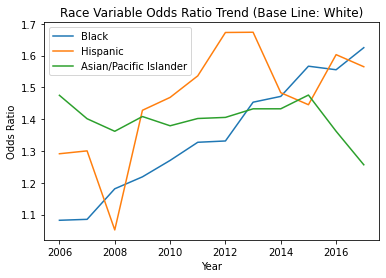

In [56]:
asianpacific = np.exp(asianpacific)
black = np.exp(black)
hispanic = np.exp(hispanic)
import seaborn as sns
years = list(range(2006, 2018))
sns.lineplot(x = years, y = black, palette = 'red', label="Black")
sns.lineplot(x = years, y = hispanic, palette = 'blue', label="Hispanic")
sns.lineplot(x = years, y = asianpacific, palette = 'green', label="Asian/Pacific Islander")
plt.title('Race Variable Odds Ratio Trend (Base Line: White)')
plt.xlabel('Year')
plt.ylabel('Odds Ratio')
plt.legend()
plt.savefig('Race_Odds_Ratio_Trend(All_Violations)')
plt.show()

### Run Analysis for each year (All Speeding Relevant)

In [57]:
num_feat = len(df_17.columns)
df_years = pd.DataFrame({'variable':list(df_17.columns)})

asianpacific = []	
black = []	
hispanic = []	
roc_auc = []

In [58]:
data_path = '/gdrive/MyDrive/traffic_stop/year_data/'
res_df = run_year_analysis(data_path, output_path = ' ', keep_col = keep_col, rm_na_col = rm_na_col, df_years = df_years, violation_type='speed')

Index(['time', 'citation_issued', 'contraband_found', 'contraband_drugs',
       'contraband_weapons', 'search_conducted', 'search_vehicle', 'yearfrac',
       'subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Metropolitan', 'county_type_Micropolitan'],
      dtype='object')
preprocessing time: 34
2006 :  Delete  search_vehicle
Optimization terminated successfully.
         Current function value: 0.678876
         Iterations 7
YEAR:  2006
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.57      0.85      0.68    184652
           1       0.56      0.22      0.32    155356

    accuracy                           0.56    340008
   macro avg       0.56      0.54      0.50    340008
weighted avg       0.56      0.56      0.51    340008

-----------------------------------------------
Index(['time', 'citation_issued', 'contraband_fo

In [59]:
roc_auc

[0.5697691412866691,
 0.5707459254838055,
 0.5758646525795456,
 0.5845700730887236,
 0.5827177579979219,
 0.5913306556249012,
 0.5979712545959575,
 0.6011174187921144,
 0.6024011298529285,
 0.6009091909761342,
 0.6074750040852038,
 0.6043946300731234]

In [ ]:
res_df

,variable,coef_2006,odds_ratio_2006,pvalue_2006,coef_2007,odds_ratio_2007,pvalue_2007,coef_2008,odds_ratio_2008,pvalue_2008,coef_2009,odds_ratio_2009,pvalue_2009,coef_2010,odds_ratio_2010,pvalue_2010,coef_2011,odds_ratio_2011,pvalue_2011,coef_2012,odds_ratio_2012,pvalue_2012,coef_2013,odds_ratio_2013,pvalue_2013,coef_2014,odds_ratio_2014,pvalue_2014,coef_2015,odds_ratio_2015,pvalue_2015,coef_2016,odds_ratio_2016,pvalue_2016,coef_2017,odds_ratio_2017,pvalue_2017
0,time,0.055731,1.057314,6.383801e-15,0.059541,1.061349,2.407399e-15,0.158499,1.171751,2.312877e-96,0.060271,1.062124,1.118084e-14,0.040033,1.040845,5.452360e-07,-0.007970,0.992062,3.267074e-01,-0.029281,0.971143,8.967235e-04,-0.052096,0.949238,2.540565e-08,-0.116559,0.889977,2.075004e-31,-0.070242,0.932168,1.737562e-11,-0.035819,0.964815,3.053070e-04,-0.095656,0.908776,7.071855e-25
1,citation_issued,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,contraband_found,2.078603,7.993294,1.674539e-119,1.955161,7.065054,3.395106e-88,2.057236,7.824315,7.055092e-93,2.096181,8.135045,7.861872e-89,2.291626,9.891004,2.642710e-114,2.040374,7.693485,1.026271e-121,2.162680,8.694403,2.001467e-87,2.170543,8.763041,2.402491e-62,2.098771,8.156143,3.433051e-52,2.286942,9.844790,2.482066e-43,2.400599,11.029780,5.918521e-57,NaN,NaN,NaN
3,contraband_drugs,-0.360620,0.697244,3.419724e-03,-0.219276,0.803100,1.143594e-01,-0.359873,0.697765,8.191375e-03,-0.100500,0.904385,4.598733e-01,0.090870,1.095127,5.050465e-01,0.409740,1.506425,9.384966e-04,0.112039,1.118556,4.174753e-01,0.182968,1.200776,2.737767e-01,0.264595,1.302903,1.338149e-01,-0.000288,0.999712,9.988589e-01,-0.157881,0.853952,3.636605e-01,NaN,NaN,NaN
4,contraband_weapons,-1.171423,0.309926,6.877439e-09,-1.179204,0.307523,5.432543e-07,-1.087277,0.337133,3.626090e-05,-1.335233,0.263097,5.788536e-09,-1.014263,0.362670,9.603896e-05,-0.525998,0.590965,6.679291e-02,-0.912007,0.401717,5.163436e-04,-0.443073,0.642060,2.190833e-01,-0.628851,0.533204,6.031382e-02,0.179577,1.196711,7.307811e-01,-0.875929,0.416475,8.272633e-03,NaN,NaN,NaN
5,search_conducted,1.266533,3.548529,0.000000e+00,1.465524,4.329811,0.000000e+00,1.241763,3.461712,0.000000e+00,0.916415,2.500311,0.000000e+00,0.821678,2.274313,0.000000e+00,0.842599,2.322396,0.000000e+00,0.974981,2.651117,0.000000e+00,1.161707,3.195383,0.000000e+00,1.078063,2.938982,1.445718e-282,1.098838,3.000677,2.945548e-249,1.120031,3.064950,8.111822e-294,NaN,NaN,NaN
6,search_vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,yearfrac,0.029396,1.029832,1.239777e-06,-0.080701,0.922470,3.563674e-37,-0.069467,0.932891,5.490866e-27,-0.200101,0.818648,3.536448e-196,-0.055639,0.945881,6.653649e-17,-0.012912,0.987171,5.978321e-02,0.071550,1.074172,1.937041e-24,0.007433,1.007461,3.136141e-01,-0.223351,0.799834,2.006769e-166,0.013747,1.013842,9.585195e-02,-0.043959,0.956993,2.146125e-08,-0.104054,0.901177,7.543209e-46
8,subject_race_asian/pacific islander,0.675768,1.965542,0.000000e+00,0.580014,1.786064,3.089973e-259,0.569638,1.767627,1.172352e-289,0.647216,1.910215,0.000000e+00,0.596317,1.815421,0.000000e+00,0.617760,1.854770,0.000000e+00,0.625390,1.868975,0.000000e+00,0.681008,1.975868,0.000000e+00,0.631388,1.880219,0.000000e+00,0.641365,1.899071,0.000000e+00,0.596173,1.815160,1.942274e-279,0.509263,1.664065,1.359275e-242
9,subject_race_black,0.181039,1.198462,2.749138e-199,0.163906,1.178104,2.253489e-143,0.249271,1.283089,3.602393e-305,0.308865,1.361879,0.000000e+00,0.339139,1.403739,0.000000e+00,0.374211,1.453844,0.000000e+00,0.363606,1.438507,0.000000e+00,0.434310,1.543897,0.000000e+00,0.453987,1.574577,0.000000e+00,0.474324,1.606927,0.000000e+00,0.479001,1.614461,0.000000e+00,0.500579,1.649676,0.000000e+00


In [ ]:
file_name = 'speeding_yearwise.csv'
save_path = '/gdrive/MyDrive/traffic_stop/output_1204/' + file_name
res_df.to_csv(save_path)

In [60]:
print(asianpacific)
print(black)
print(hispanic) 

[0.6672572410305804, 0.5809755711550514, 0.5533306941181967, 0.6299140329984052, 0.6046064306470442, 0.6333602460325592, 0.6311319988911007, 0.6772589591773703, 0.6310533001623195, 0.62915927998209, 0.5889081376276625, 0.5309971495791609]
[0.18174423184268282, 0.17061737674651764, 0.2474909184265345, 0.30540564369927226, 0.3361958409102038, 0.37672961960955603, 0.365260157953995, 0.43053457121743866, 0.45518436075844254, 0.47644333138513956, 0.47484752728756996, 0.510200807905266]
[0.3724402322094528, 0.3851319549189082, 0.10777753603484547, 0.46232747404413815, 0.5159687559206918, 0.5575658840248475, 0.6393840558673054, 0.6490016239929065, 0.5263177570078125, 0.5083086791984525, 0.5664777370183891, 0.5410806192508233]


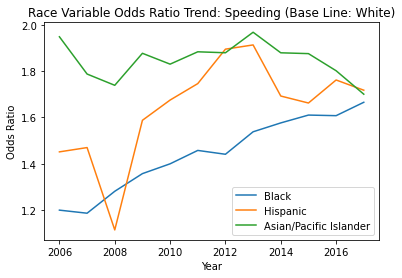

In [61]:
asianpacific = np.exp(asianpacific )
black = np.exp(black)
hispanic = np.exp(hispanic)
import seaborn as sns
years = list(range(2006, 2018))
sns.lineplot(x = years, y = black, palette = 'red', label="Black")
sns.lineplot(x = years, y = hispanic, palette = 'blue', label="Hispanic")
sns.lineplot(x = years, y = asianpacific, palette = 'green', label="Asian/Pacific Islander")
plt.title('Race Variable Odds Ratio Trend: Speeding (Base Line: White)')
plt.xlabel('Year')
plt.ylabel('Odds Ratio')
plt.legend()
plt.savefig('Race_Odds_Ratio_Trend(Speeding)')
plt.show()

### Run Analysis For each Year (Speeding is the only kind of violation)

In [ ]:
num_feat = len(df_17.columns)
df_years = pd.DataFrame({'variable':list(df_17.columns)})

asianpacific = []	
black = []	
hispanic = []	
roc_auc = []

In [ ]:
data_path = '/gdrive/MyDrive/traffic_stop/year_data/'
res_df = run_year_analysis(data_path, output_path = ' ', keep_col = keep_col, rm_na_col = rm_na_col, df_years = df_years, violation_type='speed_exclusive')

Index(['time', 'citation_issued', 'contraband_found', 'contraband_drugs',
       'contraband_weapons', 'search_conducted', 'search_vehicle', 'yearfrac',
       'subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Metropolitan', 'county_type_Micropolitan'],
      dtype='object')
preprocessing time: 30
2006 :  Delete  search_vehicle
Optimization terminated successfully.
         Current function value: 0.658490
         Iterations 5
YEAR:  2006
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.99      0.77    153446
           1       0.57      0.03      0.05     93380

    accuracy                           0.62    246826
   macro avg       0.60      0.51      0.41    246826
weighted avg       0.60      0.62      0.50    246826

-----------------------------------------------
Index(['time', 'citation_issued', 'contraband_fo

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.73      1.00      0.84    157604
           1       0.00      0.00      0.00     59291

    accuracy                           0.73    216895
   macro avg       0.36      0.50      0.42    216895
weighted avg       0.53      0.73      0.61    216895

-----------------------------------------------
Index(['time', 'citation_issued', 'contraband_found', 'contraband_drugs',
       'contraband_weapons', 'search_conducted', 'search_vehicle', 'yearfrac',
       'subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Metropolitan', 'county_type_Micropolitan'],
      dtype='object')
preprocessing time: 27
2011 :  Delete  search_vehicle
Optimization terminated successfully.
         Current function value: 0.574115
         Iterations 5
YEAR:  2011
-----------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.74      1.00      0.85    159395
           1       0.00      0.00      0.00     57441

    accuracy                           0.74    216836
   macro avg       0.37      0.50      0.42    216836
weighted avg       0.54      0.74      0.62    216836

-----------------------------------------------
Index(['time', 'citation_issued', 'contraband_found', 'contraband_drugs',
       'contraband_weapons', 'search_conducted', 'search_vehicle', 'yearfrac',
       'subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Metropolitan', 'county_type_Micropolitan'],
      dtype='object')
preprocessing time: 26
2012 :  Delete  search_vehicle
Optimization terminated successfully.
         Current function value: 0.586395
         Iterations 5
YEAR:  2012
-----------------------------------------------
              precision    recall  f1-score   su

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.71      1.00      0.83    126475
           1       0.00      0.00      0.00     52397

    accuracy                           0.71    178872
   macro avg       0.35      0.50      0.41    178872
weighted avg       0.50      0.71      0.59    178872

-----------------------------------------------


In [ ]:
res_df

,variable,coef_2006,odds_ratio_2006,pvalue_2006,coef_2007,odds_ratio_2007,pvalue_2007,coef_2008,odds_ratio_2008,pvalue_2008,coef_2009,odds_ratio_2009,pvalue_2009,coef_2010,odds_ratio_2010,pvalue_2010,coef_2011,odds_ratio_2011,pvalue_2011,coef_2012,odds_ratio_2012,pvalue_2012,coef_2013,odds_ratio_2013,pvalue_2013,coef_2014,odds_ratio_2014,pvalue_2014,coef_2015,odds_ratio_2015,pvalue_2015,coef_2016,odds_ratio_2016,pvalue_2016,coef_2017,odds_ratio_2017,pvalue_2017
0,time,0.083167,1.086723,1.222338e-21,0.103614,1.109173,9.707905e-30,0.183015,1.200833,2.896917e-83,0.099042,1.104113,9.455499e-25,0.066103,1.068337,3.807957e-11,0.032271,1.032798,1.632952e-03,-0.022703,0.977552,4.040844e-02,-0.037510,0.963185,1.389358e-03,-0.128975,0.878996,6.199717e-25,-0.095646,0.908786,2.420963e-13,-0.063469,0.938504,3.947117e-07,-0.139371,0.869905,4.153099e-32
1,citation_issued,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,contraband_found,0.478262,1.613268,1.869320e-04,0.394190,1.483182,3.707592e-03,-0.036685,0.963980,8.189694e-01,0.553920,1.740060,2.185846e-03,0.451670,1.570933,7.738067e-03,0.096946,1.101801,5.586581e-01,0.586217,1.797178,3.040060e-03,0.526986,1.693820,1.379945e-02,0.444484,1.559685,7.668232e-02,0.464218,1.590770,8.001994e-02,0.805283,2.237329,7.985711e-04,NaN,NaN,NaN
3,contraband_drugs,-0.230065,0.794482,2.037794e-01,-0.018857,0.981320,9.240204e-01,-0.175915,0.838690,4.345806e-01,-0.153271,0.857897,5.078398e-01,0.024860,1.025172,9.158420e-01,0.310717,1.364403,1.647036e-01,-0.362858,0.695685,1.620709e-01,-0.234873,0.790671,3.904130e-01,-0.423694,0.654624,1.709036e-01,0.008587,1.008624,9.783554e-01,-0.610336,0.543168,2.624016e-02,NaN,NaN,NaN
4,contraband_weapons,0.116220,1.123243,6.874003e-01,-0.320034,0.726125,3.470405e-01,-0.168749,0.844721,6.498552e-01,-0.229998,0.794535,5.204752e-01,-0.347826,0.706222,4.411076e-01,0.008171,1.008204,9.873800e-01,0.173828,1.189850,7.473906e-01,-0.347217,0.706652,5.798461e-01,-0.437851,0.645422,5.175162e-01,1.086946,2.965205,1.177298e-01,-0.937518,0.391598,1.559956e-01,NaN,NaN,NaN
5,search_conducted,0.716292,2.046830,7.951026e-226,0.930627,2.536100,0.000000e+00,0.734339,2.084104,2.741883e-186,0.217715,1.243233,6.903767e-13,0.156355,1.169241,2.755288e-07,0.123338,1.131267,1.111801e-04,0.181056,1.198482,4.835329e-07,0.375822,1.456188,4.195471e-20,0.360628,1.434230,1.653965e-15,0.482380,1.619925,1.524572e-23,0.479207,1.614794,1.912514e-27,NaN,NaN,NaN
6,search_vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,yearfrac,0.061365,1.063287,3.485559e-17,-0.092195,0.911927,8.652662e-34,-0.094544,0.909787,4.762549e-33,-0.216978,0.804947,2.949476e-156,-0.053726,0.947692,5.385006e-11,-0.021120,0.979101,1.267886e-02,0.082777,1.086300,6.865408e-22,0.002675,1.002678,7.670862e-01,-0.215221,0.806363,2.153978e-103,0.018908,1.019087,6.172323e-02,-0.077717,0.925226,8.178393e-16,-0.106076,0.899356,1.902934e-31
8,subject_race_asian/pacific islander,0.802756,2.231684,0.000000e+00,0.745946,2.108436,0.000000e+00,0.716753,2.047774,0.000000e+00,0.775719,2.172154,0.000000e+00,0.753795,2.125050,0.000000e+00,0.764295,2.147479,0.000000e+00,0.789314,2.201884,0.000000e+00,0.832647,2.299398,0.000000e+00,0.768930,2.157456,0.000000e+00,0.791905,2.207598,0.000000e+00,0.710819,2.035658,1.060697e-304,0.644819,1.905642,1.497793e-296
9,subject_race_black,0.182071,1.199699,9.367893e-139,0.142266,1.152883,1.071106e-74,0.209018,1.232467,2.349850e-143,0.217465,1.242922,5.359149e-152,0.229126,1.257500,9.598666e-163,0.262592,1.300296,2.065006e-210,0.240641,1.272064,1.372546e-168,0.282677,1.326677,2.895021e-207,0.317012,1.373018,4.307239e-231,0.298572,1.347932,4.838282e-191,0.268770,1.308354,3.924100e-172,0.256221,1.292038,6.475825e-172


In [ ]:
roc_auc

[0.5573481821575597,
 0.5550390917003408,
 0.5650866513192515,
 0.5680298972884371,
 0.559880337686564,
 0.5669462583690571,
 0.5706325296007742,
 0.5720005394705939,
 0.5828773172626907,
 0.5791530128245015,
 0.5759738488896927,
 0.5806389896848728]

In [ ]:
file_name = 'speeding_only_yearwise.csv'
save_path = '/gdrive/MyDrive/traffic_stop/output_1204/' + file_name
res_df.to_csv(save_path)

In [ ]:
print(asianpacific)
print(black)
print(hispanic) 

[0.8027562474631238, 0.7459462526738384, 0.7167531976700106, 0.7757192851458821, 0.753795335557813, 0.764294665744677, 0.7893135594800423, 0.8326474619522425, 0.7689296731811937, 0.7919051079466716, 0.7108190629650732, 0.6448189353763664]
[0.1820705266356909, 0.1422660206198858, 0.2090179547764763, 0.2174654369970981, 0.22912550650808342, 0.2625921378584809, 0.24064055110693897, 0.2826773238079633, 0.3170115796235759, 0.29857177808217694, 0.2687702338819819, 0.25622094940678314]
[0.2650381999119873, 0.2826597698120365, -0.03936750202230462, 0.3131856105316397, 0.33613533510328025, 0.37467433252335025, 0.4557479930711509, 0.4409259909119071, 0.31248697882718685, 0.26203242662184506, 0.28719977097140054, 0.25835741991992633]


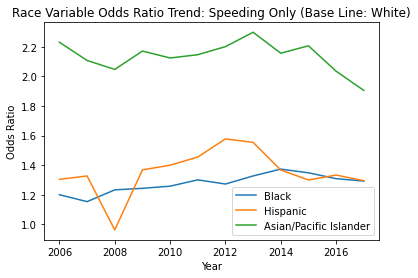

In [ ]:
asianpacific = np.exp(asianpacific )
black = np.exp(black)
hispanic = np.exp(hispanic)
import seaborn as sns
years = list(range(2006, 2018))
sns.lineplot(x = years, y = black, palette = 'red', label="Black")
sns.lineplot(x = years, y = hispanic, palette = 'blue', label="Hispanic")
sns.lineplot(x = years, y = asianpacific, palette = 'green', label="Asian/Pacific Islander")
plt.title('Race Variable Odds Ratio Trend: Speeding Only (Base Line: White)')
plt.xlabel('Year')
plt.ylabel('Odds Ratio')
plt.legend()
plt.savefig('Race_Odds_Ratio_Trend(Speeding_Only)')
plt.show()